In [2]:
import numpy as np # importing numpy
import pandas as pd # importing pandas
import matplotlib.pyplot as plt # importing pyplot

In [3]:
# reading the csv file
df = pd.read_csv("/content/drive/MyDrive/Dataset/diabetes_.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
# Replacing all the data with value 0 with NA.
df[cols_with_zero] = df[cols_with_zero].replace(0, pd.NA)


In [6]:
#Checking missing values after changing to NA
df.isnull().sum()



,0
Pregnancies,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [7]:
# Summary statistics
print(df.describe())


       Pregnancies  DiabetesPedigreeFunction         Age     Outcome
count   768.000000                768.000000  768.000000  768.000000
mean      3.845052                  0.471876   33.240885    0.348958
std       3.369578                  0.331329   11.760232    0.476951
min       0.000000                  0.078000   21.000000    0.000000
25%       1.000000                  0.243750   24.000000    0.000000
50%       3.000000                  0.372500   29.000000    0.000000
75%       6.000000                  0.626250   41.000000    1.000000
max      17.000000                  2.420000   81.000000    1.000000


In [8]:
#Filling the missing values in the dataset with median
df.fillna(df.median(), inplace=True)

/tmp/ipython-input-2377062450.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(df.median(), inplace=True)


In [9]:
#Checking missing values again after filling
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [10]:
# # Features = all columns except Outcome, Target = Outcome column
X = df.drop(columns=['Outcome']).values
y = df['Outcome'].values

#Define a function for train-test split from scratch
def train_test_split_scratch(X,Y, test_size=0.3, random_seed=50):
  """
  Splits dataset into train and test sets.
  Arguments:

  X : np.ndarray
  Feature matrix.

  y : np.ndarray
  Target array.

  test_size : float

  Proportion of the dataset to include in the test split (0 < test_size < 1).

  random_seed : int

  Seed for reproducibility.

  Returns:
  X_train, X_test, y_train, y_test : np.ndarray
  Training and testing splits of features and target.
  """
  np.random.seed(random_seed)

  indices = np.arange(X.shape[0]) #taking number of rows since X.shape[0] returns the rows.
  np.random.shuffle(indices) # to reduce sampling bias we shuffle the indices

  #splitting the test data
  test_split_size = int(len(X) * test_size)
  test_indices = indices[:test_split_size]
  train_indices = indices[test_split_size:]
  X_train, X_test = X[train_indices], X[test_indices]
  y_train, y_test = y[train_indices], y[test_indices]
  return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = train_test_split_scratch(X, y, test_size=0.3)
# Output shapes to verify
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (538, 8)
Shape of X_test: (230, 8)
Shape of y_train: (538,)
Shape of y_test: (230,)


In [11]:
def euclidean_distance(point1, point2):
  """
  Calculate the Euclidean distance between two points in n-dimensional space.
  Arguments:
  point1 : np.ndarray
  The first point as a numpy array.
  point2 : np.ndarray
  The second point as a numpy array.
  Returns:
  float
  The Euclidean distance between the two points.
  Raises:
  ValueError: If the input points do not have the same dimensionality.
  """
  # Check if the points are of the same dimension
  if point1.shape != point2.shape:
    raise ValueError("Points must have the same dimensions to calculate Euclidean distance.")
  # Calculate the Euclidean distance
  distance = np.sqrt(np.sum((point1 - point2) ** 2))
  return distance

In [12]:
def knn_predict_single(query, X_train, y_train, k=3):
  """
  Predict the class label for a single query using the K-nearest neighbors algorithm.
  Arguments:
  query : np.ndarray
  The query point for which the prediction is to be made.
  X_train : np.ndarray
  The training feature matrix.
  y_train : np.ndarray
  The training labels.
  k : int, optional
  The number of nearest neighbors to consider (default is 3).
  Returns:
  int
  The predicted class label for the query.
  """
  distances = [euclidean_distance(query, x) for x in X_train]
  sorted_indices = np.argsort(distances)
  nearest_indices = sorted_indices[:k]
  nearest_labels = y_train[nearest_indices]
  prediction = np.bincount(nearest_labels).argmax()
  return prediction

In [13]:
def knn_predict(X_test, X_train, y_train, k=3):
  """
  Predict the class labels for all test samples using the K-nearest neighbors algorithm.
  Arguments:
  X_test : np.ndarray
  The test feature matrix.
  X_train : np.ndarray
  The training feature matrix.
  y_train : np.ndarray
  The training labels.
  k : int, optional
  The number of nearest neighbors to consider (default is 3).
  Returns:

  7

  5CS037 Worksheet - 4:Implementation of k-Nearest Neighbor from Scratch. Siman Giri

  np.ndarray
  An array of predicted class labels for the test samples.
  """
  predictions = [knn_predict_single(x, X_train, y_train, k) for x in X_test]
  return np.array(predictions)

In [14]:
# Test case for KNN on the Diabetes dataset
# Assume X_train, X_test, y_train, and y_test have been prepared

try:
    # Define the test set for the test case
    X_test_sample = X_test[:5]  # Taking a small subset for testing
    y_test_sample = y_test[:5]  # Corresponding labels for the subset

    # Make predictions
    predictions = knn_predict(X_test_sample, X_train, y_train, k=3)

    # Print test results
    print("Predictions:", predictions)
    print("Actual labels:", y_test_sample)

    # Check if predictions match expected format
    assert predictions.shape == y_test_sample.shape, \
        "The shape of predictions does not match the shape of the actual labels."

    print("Test case passed successfully!")

except AssertionError as ae:
    print(f"AssertionError: {ae}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Predictions: [0 1 0 0 0]
Actual labels: [0 1 0 0 0]
Test case passed successfully!


In [15]:
def accuracy(y_true, y_pred):
  """
  Compute the accuracy of predictions as a percentage.

  Arguments:
  y_true : np.ndarray
      True labels (actual values).
  y_pred : np.ndarray
      Predicted labels from your model.

  Returns:
  float
      Accuracy as a percentage (0–100).
  """
  return (np.sum(y_true == y_pred) / len(y_true)) * 100


In [16]:
# Predict labels for the full test set using KNN with k=3
y_pred_full = knn_predict(X_test, X_train, y_train, k=3)

# Calculate the accuracy of predictions
full_acc = accuracy(y_test, y_pred_full)

# Print the accuracy in percentage.
print(f"Accuracy on full test set: {round(full_acc, 2)}%")


Accuracy on full test set: 68.7%


In [17]:
# Compute mean and std of each feature
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

# Scale training and test data
X_train_scaled = (X_train - mean) / std
X_test_scaled = (X_test - mean) / std

# Run KNN on scaled data
y_pred_scaled = knn_predict(X_test_scaled, X_train_scaled, y_train, k=3)

# Compute accuracy
scaled_acc = accuracy(y_test, y_pred_scaled)
print(f"Accuracy with scaled features: {round(scaled_acc, 2)}")




Accuracy with scaled features: 70.43


### Comparative Analysis of KNN on Original vs Scaled Data

**Accuracy:**
- Original dataset: 68.7%
- Scaled dataset: 70.43%

**Impact of scaling:**
- Scaling improve the accuracy of KNN slightly since it uses distance to find neighbours and predict the target value. Since data like glucose have a higher quantifying value, without scaling it dominates the overall distance calculation

**Reason scaling improved Accuracy:**
- After Scaling, all the feature values come to be similar level improving the less bias calculation. Hence, Improving the overall calculation of the model

In [18]:
import matplotlib.pyplot as plt
import time

def experiment_knn_k_values_with_time(X_train, y_train, X_test, y_test, k_values):
    """
    Runs KNN for multiple k values, records accuracy and prediction time,
    and plots the results.

    Parameters:
    X_train, y_train : training data and labels
    X_test, y_test : test data and labels
    k_values : list or range of k values to try

    Returns:
    accuracies : dict of accuracy (%) for each k
    times : dict of prediction time (seconds) for each k
    """
    accuracies = {}
    times = {}

    for k in k_values:
        # Record start time
        start = time.time()

        # Make predictions
        predictions = knn_predict(X_test, X_train, y_train, k=k)

        # Record end time
        end = time.time()

        # Compute accuracy
        acc = accuracy(y_test, predictions)

        # Store results
        accuracies[k] = acc
        times[k] = end - start

        print(f"k={k}: Accuracy={acc:.2f}%, Time={times[k]:.4f} seconds")

    # Plot accuracy vs k
    plt.figure(figsize=(10, 5))
    plt.plot(list(k_values), list(accuracies.values()), marker='o', label='Accuracy (%)')
    plt.xlabel('k (Number of Neighbors)')
    plt.ylabel('Accuracy (%)')
    plt.title('k vs Accuracy')
    plt.grid(True)
    plt.show()

    # Plot time vs k
    plt.figure(figsize=(10, 5))
    plt.plot(list(k_values), list(times.values()), marker='o', color='red', label='Time (s)')
    plt.xlabel('k (Number of Neighbors)')
    plt.ylabel('Time (seconds)')
    plt.title('k vs Prediction Time')
    plt.grid(True)
    plt.show()

    return accuracies, times


k=1: Accuracy=67.39%, Time=0.8593 seconds
k=2: Accuracy=70.43%, Time=0.9039 seconds
k=3: Accuracy=68.70%, Time=1.4953 seconds
k=4: Accuracy=73.04%, Time=1.4672 seconds
k=5: Accuracy=70.87%, Time=1.3976 seconds
k=6: Accuracy=71.74%, Time=0.9099 seconds
k=7: Accuracy=70.87%, Time=0.8760 seconds
k=8: Accuracy=71.30%, Time=0.8707 seconds
k=9: Accuracy=71.30%, Time=0.8586 seconds
k=10: Accuracy=72.17%, Time=0.8331 seconds
k=11: Accuracy=69.13%, Time=0.8537 seconds
k=12: Accuracy=70.87%, Time=0.8665 seconds
k=13: Accuracy=70.87%, Time=0.9654 seconds
k=14: Accuracy=70.43%, Time=0.9242 seconds
k=15: Accuracy=71.30%, Time=0.9117 seconds


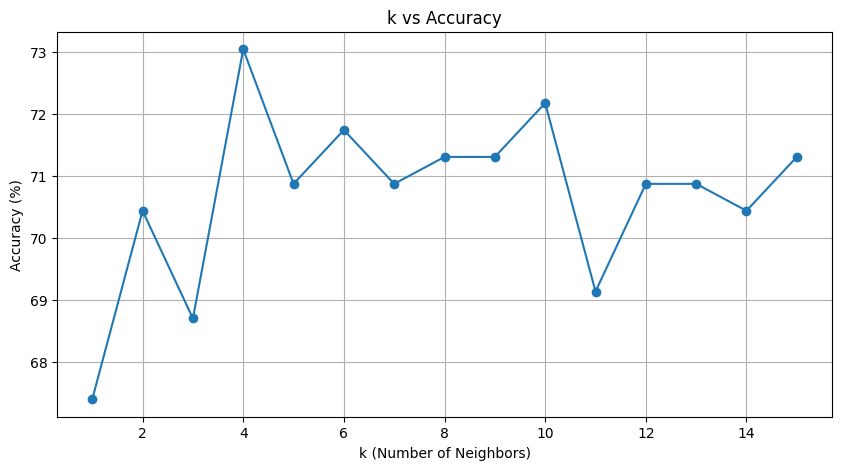

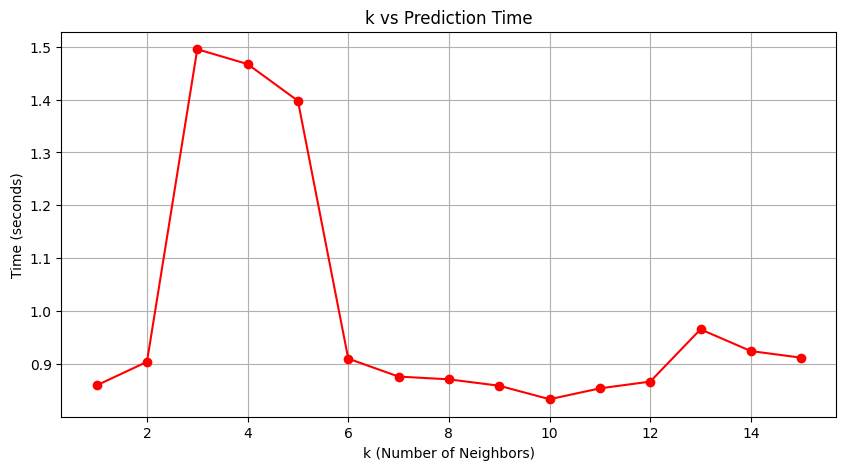

Experiment completed. Check the plots for trends.


In [19]:
k_values = range(1, 16)  # k = 1 to 15

try:
    accuracies, times = experiment_knn_k_values_with_time(X_train, y_train, X_test, y_test, k_values)
    print("Experiment completed. Check the plots for trends.")
except Exception as e:
    print(f"An error occurred: {e}")


k=1: Accuracy=68.26%, Time=1.0963 seconds
k=2: Accuracy=71.74%, Time=1.6700 seconds
k=3: Accuracy=70.43%, Time=1.6848 seconds
k=4: Accuracy=71.74%, Time=1.5246 seconds
k=5: Accuracy=70.87%, Time=1.1243 seconds
k=6: Accuracy=73.48%, Time=0.8639 seconds
k=7: Accuracy=73.04%, Time=0.8685 seconds
k=8: Accuracy=71.30%, Time=0.8747 seconds
k=9: Accuracy=75.22%, Time=0.8900 seconds
k=10: Accuracy=74.35%, Time=0.8578 seconds
k=11: Accuracy=76.52%, Time=0.8787 seconds
k=12: Accuracy=73.48%, Time=0.8326 seconds
k=13: Accuracy=73.48%, Time=0.8611 seconds
k=14: Accuracy=75.22%, Time=0.8517 seconds
k=15: Accuracy=75.22%, Time=0.8579 seconds


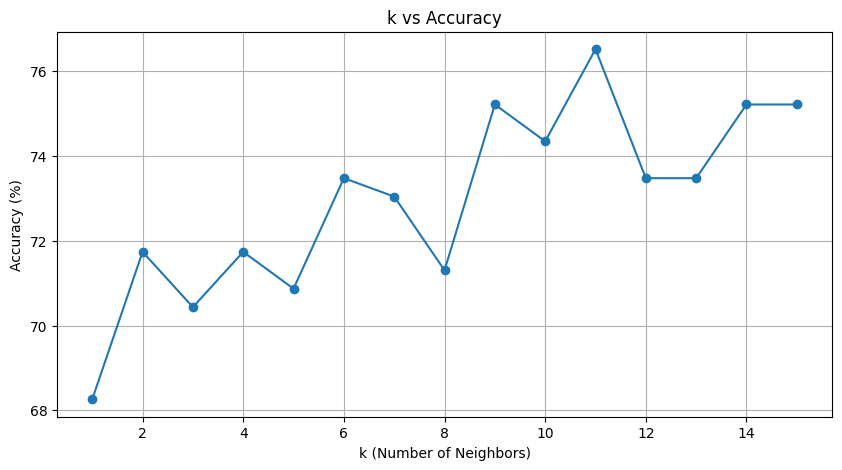

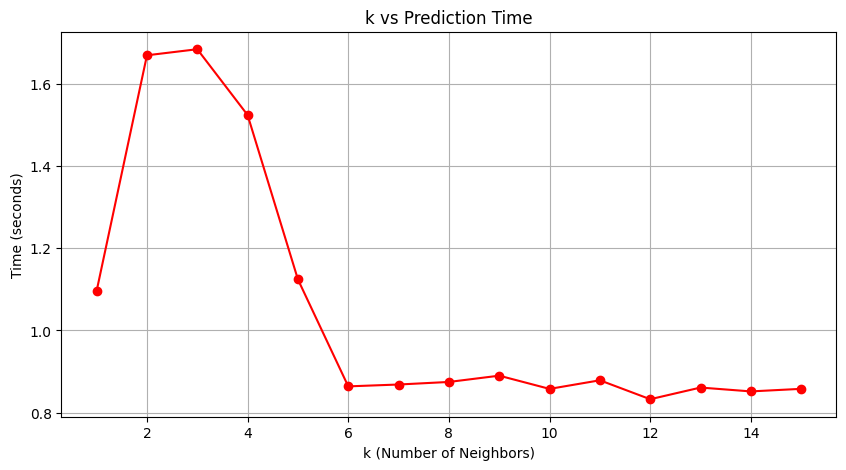

Experiment completed. Check the plots for trends.


In [20]:
k_values = range(1, 16)  # k = 1 to 15

try:
    accuracies, times = experiment_knn_k_values_with_time(X_train_scaled, y_train, X_test_scaled, y_test, k_values)
    print("Experiment completed. Check the plots for trends.")
except Exception as e:
    print(f"An error occurred: {e}")


### Problem 3: Experimentation with k

We tested the KNN classifier for k values from 1 to 15 on the diabetes dataset, recording both **accuracy** and **prediction time**.

**Accuracy vs k:**  
- Accuracy varies with k. in Our experiment the accuracy vs k were lower in small values of k (1-2) due to noise. it stablized in higher values of k (3-15) with average value of k being at around **70%** while highest accuracy being at **k=4 with Accuracy=73.04%**

- **k=4** was the sweet spot where it was high enough to reduce noise and outliers and small enough to not get affected with distant unrelated data

**Time vs k:**  
- Prediction time stays mostly constant because computing distances takes up most of the time. k only becomes significant in slicing the first k values from the sorted array which is very fast. So larger values of k doesnt affect the time

### Problem 4: Additional Questions

**Challenges of KNN for large datasets and high-dimensional data:**  
- KNN becomes slower on larger datasets because it needs to compute distances for more test points, which makes it computationally heavy.

- For **high-dimensional data** KNN becomes less accurate because of curse of dimentionality. in higher dimensional data the computing distances become similar so the accuracy. If we keep adding features those features will act as noise. making KNN accuracy significantly lower


**Strategies to improve efficiency of KNN:**  
- **Dimensionality reduction:** Since KNN struggles with higher dimension we can remove the number of featuers while keeping the most information intact.

- **Approximate nearest neighbors:** Algorithms like KD-Trees, Ball Trees, or locality-sensitive hashing can find neighbors faster than brute-force search.

- **Reduce training set size or indexing:** Sampling the training data or building efficient data structures can decrease computation time.  

